# Tarefa: criando um reconhecedor de dígitos falados com uma CNN-1D
Criar um notebook Python que demonstre o uso de uma rede neural convolucional 1D para reconhecer categorias de áudios (números falados) no formato WAV. O notebook deve obter um banco de dados de áudio  realizar pré-processamentos para obter clipes curtos de áudio, dividir os dados em treinamento, validação e teste, definir e treinar a arquitetura do modelo CNN 1D, visualizar as perdas de treinamento e validação, usar critério de parada por callback de paciência, visualizar a matriz de confusão no conjunto de teste e, na parte final, repetir o experimento incluindo estratégia de aumento de dados para áudio.

* Realize o que é solicitado nas linhas de comentários sinalizadas por ***

* Ao concluir a tarefa, manter o notebook com todas as células de saída salvas e forncer o link do notebook (com compartilhamento para leitura para qualquer pessoa com o link) na tarefa correspondente na plataforma do curso.


## Configuração inicial

Instalar as bibliotecas e importar os módulos necessários.

In [ ]:
!pip install tensorflow numpy matplotlib scipy scikit-learn librosa soundfile

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.metrics
import tensorflow.keras.models
import tensorflow.keras.layers
import tensorflow.keras.callbacks

## Obtenção e carregamento dos dados

Baixar o conjunto de dados de áudio e listar os arquivos WAV.

Free Spoken Digit Dataset (FSDD): é um conjunto de dados aberto de áudio/fala, composto por gravações de dígitos falados em arquivos wav a 8 kHz. As gravações são aparadas para que tenham silêncio quase mínimo no início e no fim. São 6 falantes,  3.000 gravações em inglês (50 de cada dígito por falante).


In [ ]:
import urllib.request
import zipfile
import os

# URL for the Free Spoken Digit Dataset
url = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip"
filename = "free-spoken-digit-dataset.zip"
extract_dir = "free-spoken-digit-dataset-master" # The name of the extracted folder

# Download the dataset
print(f"Downloading {filename}...")
urllib.request.urlretrieve(url, filename)
print("Download complete.")

# Extract the dataset
print(f"Extracting {filename}...")
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(".")
print("Extraction complete.")

# List all WAV files in the extracted directory
wav_files = []
for root, _, files in os.walk(extract_dir):
    for file in files:
        if file.endswith(".wav"):
            wav_files.append(os.path.join(root, file))

print(f"\nFound {len(wav_files)} WAV files:")
for i, wav_file in enumerate(wav_files[:10]): # Print only the first 10 for brevity
    print(wav_file)

Download complete.
Extracting free-spoken-digit-dataset.zip...
Extraction complete.

Found 3000 WAV files:
free-spoken-digit-dataset-master/recordings/5_theo_17.wav
free-spoken-digit-dataset-master/recordings/5_nicolas_3.wav
free-spoken-digit-dataset-master/recordings/0_lucas_13.wav
free-spoken-digit-dataset-master/recordings/1_yweweler_19.wav
free-spoken-digit-dataset-master/recordings/1_george_38.wav
free-spoken-digit-dataset-master/recordings/0_lucas_21.wav
free-spoken-digit-dataset-master/recordings/9_yweweler_25.wav
free-spoken-digit-dataset-master/recordings/9_yweweler_10.wav
free-spoken-digit-dataset-master/recordings/3_yweweler_41.wav
free-spoken-digit-dataset-master/recordings/7_yweweler_36.wav


Pré-processar os arquivos de áudio: carregar, dividir em clipes curtos de duração fixa e garantir dimensão uniforme.

In [ ]:
# Define parameters for clipping
clip_duration = 1 # seconds
sample_rate = 8000 # to match FSDD dataset

# List to store processed audio clips and their labels
audio_clips = []
labels = []

print(f"Processing {len(wav_files)} audio files...")

for wav_file in wav_files:
    try:
        # Load the audio file
        audio, sr = librosa.load(wav_file, sr=sample_rate)

        # Extract the digit label from the filename (e.g., "free-spoken-digit-dataset-master/recordings/7_jackson_35.wav" -> 7)
        label = int(os.path.basename(wav_file).split('_')[0])

        # Calculate the number of samples per clip
        samples_per_clip = int(clip_duration * sr)

        # Split the audio into clips
        for i in range(0, len(audio), samples_per_clip):
            clip = audio[i:i + samples_per_clip]

            # Pad shorter clips with zeros if necessary
            if len(clip) < samples_per_clip:
                clip = np.pad(clip, (0, samples_per_clip - len(clip)), 'constant')

            audio_clips.append(clip)
            labels.append(label)

    except Exception as e:
        print(f"Error processing {wav_file}: {e}")

audio_clips = np.array(audio_clips)
labels = np.array(labels)

print(f"\nFinished processing. Created {len(audio_clips)} audio clips.")
print(f"Shape of audio_clips array: {audio_clips.shape}")
print(f"Shape of labels array: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")

Processing 3000 audio files...

Finished processing. Created 3022 audio clips.
Shape of audio_clips array: (3022, 8000)
Shape of labels array: (3022,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


Preparar os dados para treinamento: Codificar os rótulos e dividir o conjunto de dados em treinamento, validação e teste.

In [ ]:
# Encode the labels
label_encoder = sklearn.preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Convert to one-hot encoding
one_hot_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=num_classes)

print(f"Original labels (first 10): {labels[:10]}")
print(f"Encoded labels (first 10): {encoded_labels[:10]}")
print(f"One-hot encoded labels shape: {one_hot_labels.shape}")
print(f"Number of classes: {num_classes}")

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(
    audio_clips, one_hot_labels, test_size=0.3, random_state=42, stratify=one_hot_labels
)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nShape of training data: {X_train.shape}")
print(f"Shape of validation data: {X_val.shape}")
print(f"Shape of test data: {X_test.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of validation labels: {y_val.shape}")
print(f"Shape of test labels: {y_test.shape}")

Original labels (first 10): [5 5 0 1 1 0 9 9 3 7]
Encoded labels (first 10): [5 5 0 1 1 0 9 9 3 7]
One-hot encoded labels shape: (3022, 10)
Number of classes: 10

Shape of training data: (2115, 8000)
Shape of validation data: (453, 8000)
Shape of test data: (454, 8000)
Shape of training labels: (2115, 10)
Shape of validation labels: (453, 10)
Shape of test labels: (454, 10)


Reduzir o número de classes  e amostras por classe - CANCELADO -> não é mais necessária

In [ ]:
#***Não precisa mais fazer essa parte abaixo, pois o dataset já está suficientemente pequeno
#"Para facilitar a tarefa, inclua código para trabalhar apenas com metade do número de classes e do número de amostras por classe

## Definição e Treinamento do Modelo CNN 1D

Definir a arquitetura da rede neural convolucional 1D.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# Defina o modelo 1D CNN
model = tf.keras.models.Sequential([
    # Bloco 1
    layers.Conv1D(filters=32, kernel_size=13, activation='relu',
                  input_shape=(X_train.shape[1], 1),
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    # Bloco 2
    layers.Conv1D(filters=64, kernel_size=11, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    # Camadas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')  # saída
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7988, 32)       │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3994, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3994, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3984, 64)       │        22,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1992, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1992, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 127488)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,318,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,342,922 (62.34 MB)

 Trainable params: 16,342,922 (62.34 MB)

 Non-trainable params: 0 (0.00 B)

Compilar e treinar o modelo.

In [ ]:
# Compile the model
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20, # You can set a higher number of epochs as Early Stopping will prevent overfitting
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.1134 - loss: 2.3468 - val_accuracy: 0.1523 - val_loss: 2.3430
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.1516 - loss: 2.3395 - val_accuracy: 0.1656 - val_loss: 2.3376
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.1617 - loss: 2.3306 - val_accuracy: 0.1634 - val_loss: 2.3318
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.1781 - loss: 2.3200 - val_accuracy: 0.1832 - val_loss: 2.3226
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.1731 - loss: 2.3128 - val_accuracy: 0.1744 - val_loss: 2.3175
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.1772 - loss: 2.3059 - val_accuracy: 0.1523 - val_loss: 2.3066
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1736 - loss: 2.2880 - val_accuracy: 0.1523 - val_loss: 2.2987
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1846 - loss: 2.2669 - val_accuracy: 0.1987 -

Visualizar as perdas de treinamento e validação.

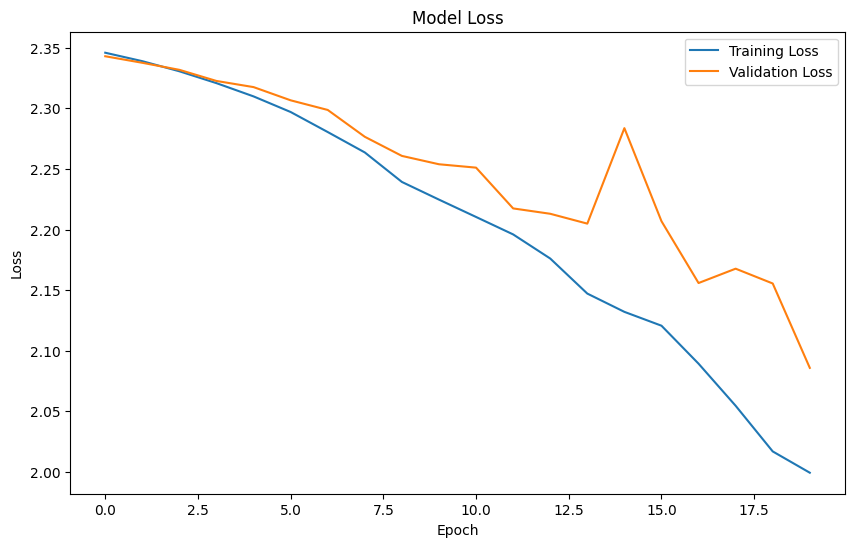

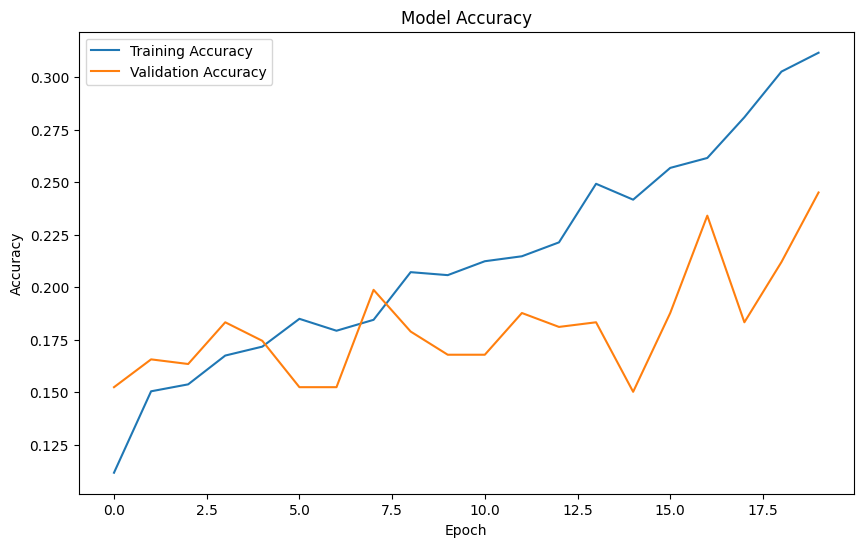

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Avaliação do Modelo: Avaliar o desempenho no conjunto de teste e visualizar a matriz de confusão.

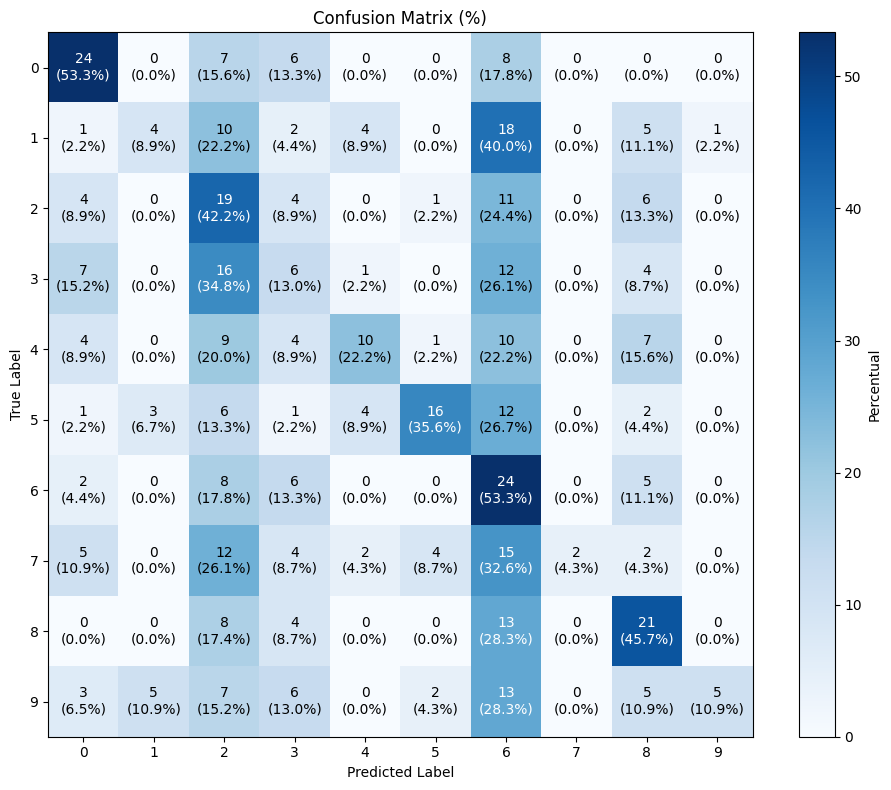

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusão
cm = sklearn.metrics.confusion_matrix(y_true_classes, y_pred_classes)

# Calcular percentuais
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
plt.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (%)')
plt.colorbar(label='Percentual')

# Marcar ticks
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, label_encoder.classes_)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adicionar valores nas células
thresh = cm_percent.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)",
                 ha="center", va="center",
                 color="white" if cm_percent[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


## Registro de Experimentos - CNN 1D Áudio

### Arquitetura 1
- Conv1D: 32 filtros, kernel=13, L2=0.001, Dropout=0.3
- Conv1D: 64 filtros, kernel=11, L2=0.001, Dropout=0.3
- Dense: 128 unidades, Dropout=0.4
- Otimizador: SGD
- Test Accuracy: 0.9420



## Aumento de Dados para Áudio

Implementar uma estratégia de aumento de dados para áudio (por exemplo, adicionando ruído, deslocamento de tempo, etc.).

In [ ]:
import random

def augment_audio(audio_clip, sample_rate):
    """Applies random data augmentation to an audio clip."""
    augmented_clip = audio_clip.copy()

    # Add random noise
    if random.random() < 0.5:
        noise_amplitude = 0.005 * np.random.uniform() * np.amax(augmented_clip)
        augmented_clip = augmented_clip + noise_amplitude * np.random.normal(size=augmented_clip.shape[0])

    # Time shifting
    if random.random() < 0.5:
        shift_amount = random.randint(-int(sample_rate * 0.1), int(sample_rate * 0.1))
        augmented_clip = np.roll(augmented_clip, shift_amount)

    # You can add more augmentation techniques here, e.g., pitch shifting, stretching, etc.

    return augmented_clip

# Apply augmentation to the training data
X_train_augmented = np.array([augment_audio(clip, sample_rate) for clip in X_train])

print(f"Shape of original training data: {X_train.shape}")
print(f"Shape of augmented training data: {X_train_augmented.shape}")

Shape of original training data: (2115, 8000)
Shape of augmented training data: (2115, 8000)


Repetição do Experimento com Aumento de Dados: Compilar e treinar o modelo novamente utilizando os dados de treinamento aumentados.

In [ ]:
# Redimensiona os dados para (amostras, tempo, canais)
X_train_augmented = X_train_augmented.reshape(-1, X_train.shape[1], 1)
X_val = X_val.reshape(-1, X_val.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# Define novamente a arquitetura (pode ser a mesma ou ajustada)
model_augmented = tf.keras.models.Sequential([
    # Bloco 1
    layers.Conv1D(filters=32, kernel_size=13, activation='relu',
                  input_shape=(X_train.shape[1], 1),
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    # Bloco 2
    layers.Conv1D(filters=64, kernel_size=11, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    # Camadas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# Compilação
model_augmented.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Callback de Early Stopping
early_stopping_augmented = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Treinamento
print("Training model with augmented data...")
history_augmented = model_augmented.fit(
    X_train_augmented, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_augmented]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model with augmented data...
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.1452 - loss: 2.3069 - val_accuracy: 0.3091 - val_loss: 1.9815
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3225 - loss: 1.8591 - val_accuracy: 0.3996 - val_loss: 1.5915
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.4544 - loss: 1.5096 - val_accuracy: 0.5475 - val_loss: 1.2787
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5897 - loss: 1.1724 - val_accuracy: 0.5762 - val_loss: 1.2197
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6636 - loss: 0.9450 - val_accuracy: 0.6071 - val_loss: 1.1845
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7197 - loss: 0.8306 - val_accuracy: 0.5894 - val_loss: 1.1774
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7620 - loss: 0.7163 - val_accuracy: 0.6424 - val_loss: 1.1837
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8055 -

Visualizar as perdas de treinamento e validação com aumento de dados.

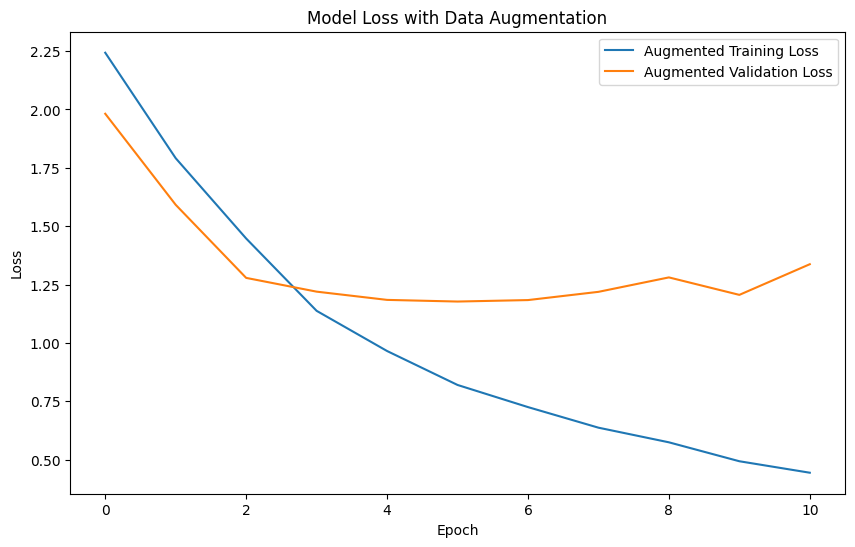

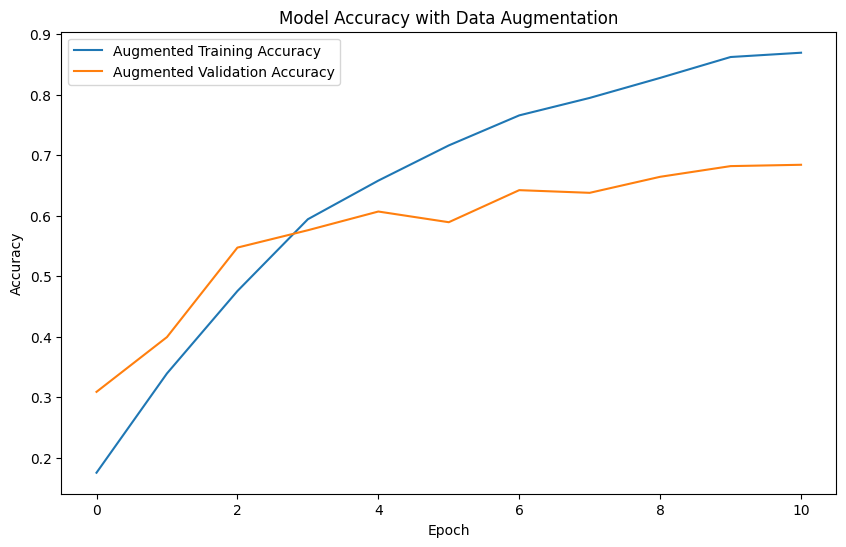

In [ ]:
# Plot training and validation loss for augmented data
plt.figure(figsize=(10, 6))
plt.plot(history_augmented.history['loss'], label='Augmented Training Loss')
plt.plot(history_augmented.history['val_loss'], label='Augmented Validation Loss')
plt.title('Model Loss with Data Augmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation accuracy for augmented data
plt.figure(figsize=(10, 6))
plt.plot(history_augmented.history['accuracy'], label='Augmented Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Augmented Validation Accuracy')
plt.title('Model Accuracy with Data Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Avaliar o modelo com aumento de dados no conjunto de teste e visualizar a matriz de confusão.

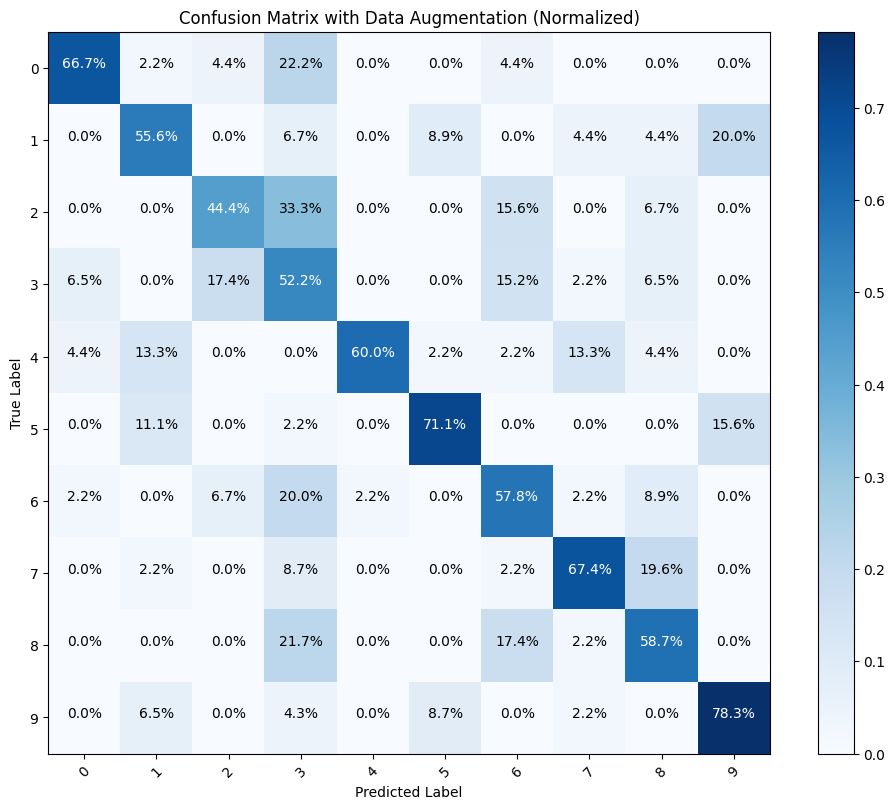

In [ ]:
import itertools

# Calcular matriz de confusão normalizada (por linha)
cm_normalized = confusion_matrix_augmented.astype('float') / confusion_matrix_augmented.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix with Data Augmentation (Normalized)')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)

# Adicionar os valores dentro de cada célula
thresh = cm_normalized.max() / 2.
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
    plt.text(j, i, f"{cm_normalized[i, j]*100:.1f}%",
             horizontalalignment="center",
             color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
# ***Com base nos resultados, aprimore a função que faz aumento de dados e repita o treinamento para conseguir um resultado ainda melhor

In [ ]:
import random
import librosa

def augment_audio_improved(audio_clip, sample_rate):
    """
    Aplica uma ou duas técnicas de aumento de dados de forma aleatória a um clipe de áudio.
    Técnicas incluídas: adicionar ruído, deslocamento de tempo, mudança de tom e esticamento do tempo.
    """
    augmented_clip = audio_clip.copy()

    # Lista de possíveis funções de aumento de dados
    augmentation_functions = [
        # 1. Adicionar ruído com uma amplitude um pouco maior
        lambda clip: clip + 0.01 * np.random.uniform() * np.amax(clip) * np.random.normal(size=clip.shape[0]),

        # 2. Deslocamento de tempo (Time Shifting)
        lambda clip: np.roll(clip, random.randint(-int(sample_rate * 0.1), int(sample_rate * 0.1))),

        # 3. Mudança de tom (Pitch Shifting) - simula vozes diferentes (mais graves/agudas)
        lambda clip: librosa.effects.pitch_shift(y=clip, sr=sample_rate, n_steps=random.uniform(-2, 2)),

        # 4. Esticamento do tempo (Time Stretching) - simula falas mais rápidas ou lentas
        lambda clip: librosa.effects.time_stretch(y=clip, rate=random.uniform(0.8, 1.2))
    ]

    # Escolhe aleatoriamente 1 ou 2 transformações para aplicar
    num_augmentations_to_apply = random.randint(1, 2)
    augmentations_to_apply = random.sample(augmentation_functions, num_augmentations_to_apply)

    # Aplica as transformações escolhidas
    for func in augmentations_to_apply:
        augmented_clip = func(augmented_clip)

    # Garante que o clipe de áudio mantenha o mesmo tamanho original após o time stretching
    if len(augmented_clip) < len(audio_clip):
        # Se for mais curto, preenche com zeros (padding)
        augmented_clip = np.pad(augmented_clip, (0, len(audio_clip) - len(augmented_clip)), 'constant')
    elif len(augmented_clip) > len(audio_clip):
        # Se for mais longo, trunca
        augmented_clip = augmented_clip[:len(audio_clip)]


    return augmented_clip

In [ ]:
# Aplicar a nova função de aumento de dados aprimorada
X_train_augmented_improved = np.array([augment_audio_improved(clip, sample_rate) for clip in X_train])

# Redimensionar os dados para o formato esperado pela CNN: (amostras, passos de tempo, canais)
X_train_augmented_improved = X_train_augmented_improved.reshape(-1, X_train_augmented_improved.shape[1], 1)
# X_val e X_test já devem estar no formato correto do experimento anterior, mas garantimos aqui
X_val_reshaped = X_val.reshape(-1, X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(-1, X_test.shape[1], 1)


# Redefinir e compilar o modelo para um novo treinamento
model_augmented_improved = tf.keras.models.Sequential([
    layers.Conv1D(filters=32, kernel_size=13, activation='relu',
                  input_shape=(X_train.shape[1], 1),
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    layers.Conv1D(filters=64, kernel_size=11, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model_augmented_improved.compile(optimizer='adam',
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

# Novo callback de Early Stopping
early_stopping_improved = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Aumentamos a paciência para dar mais chance ao modelo
    restore_best_weights=True
)

# Treinar o modelo com os novos dados aumentados
print("\nTreinando o modelo com os dados aumentados e aprimorados...")
history_augmented_improved = model_augmented_improved.fit(
    X_train_augmented_improved, y_train,
    epochs=50,  # O Early Stopping cuidará para não treinar demais
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping_improved]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Treinando o modelo com os dados aumentados e aprimorados...
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.1195 - loss: 2.3071 - val_accuracy: 0.2759 - val_loss: 2.0506
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.3050 - loss: 1.9305 - val_accuracy: 0.4945 - val_loss: 1.6049
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4379 - loss: 1.5533 - val_accuracy: 0.5143 - val_loss: 1.4230
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5449 - loss: 1.2463 - val_accuracy: 0.5475 - val_loss: 1.3270
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6430 - loss: 1.0355 - val_accuracy: 0.5563 - val_loss: 1.2753
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6959 - loss: 0.8724 - val_accuracy: 0.6159 - val_loss: 1.2407
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7447 - loss: 0.7706 - val_accuracy: 0.6225 - val_loss: 1.2445
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/s

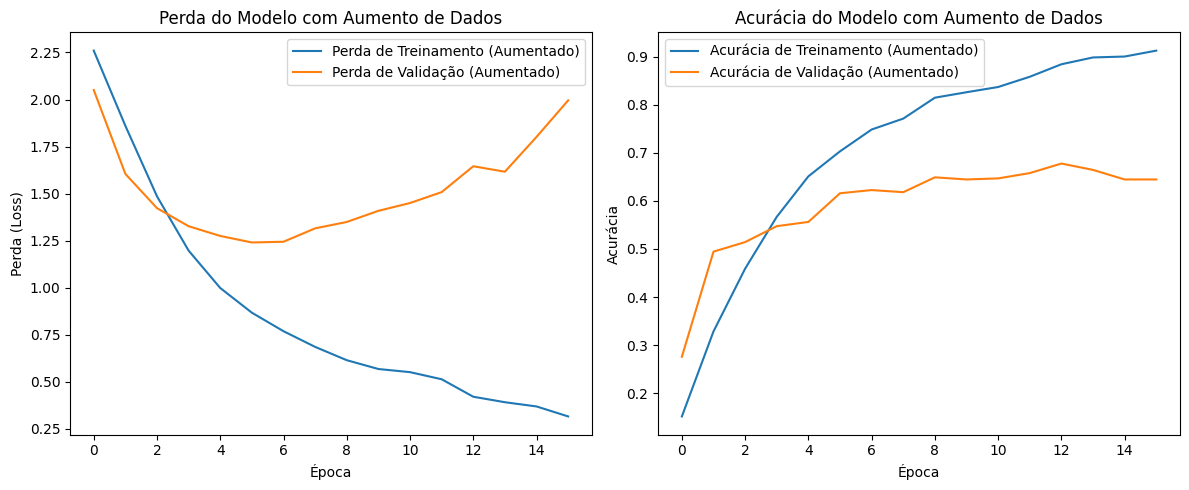

In [ ]:
# Plotar as perdas de treinamento e validação com os dados aprimorados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_augmented_improved.history['loss'], label='Perda de Treinamento (Aumentado)')
plt.plot(history_augmented_improved.history['val_loss'], label='Perda de Validação (Aumentado)')
plt.title('Perda do Modelo com Aumento de Dados')
plt.ylabel('Perda (Loss)')
plt.xlabel('Época')
plt.legend()

# Plotar as acurácias de treinamento e validação com os dados aprimorados
plt.subplot(1, 2, 2)
plt.plot(history_augmented_improved.history['accuracy'], label='Acurácia de Treinamento (Aumentado)')
plt.plot(history_augmented_improved.history['val_accuracy'], label='Acurácia de Validação (Aumentado)')
plt.title('Acurácia do Modelo com Aumento de Dados')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()

plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Acurácia no conjunto de teste (com aumento de dados): 0.6366


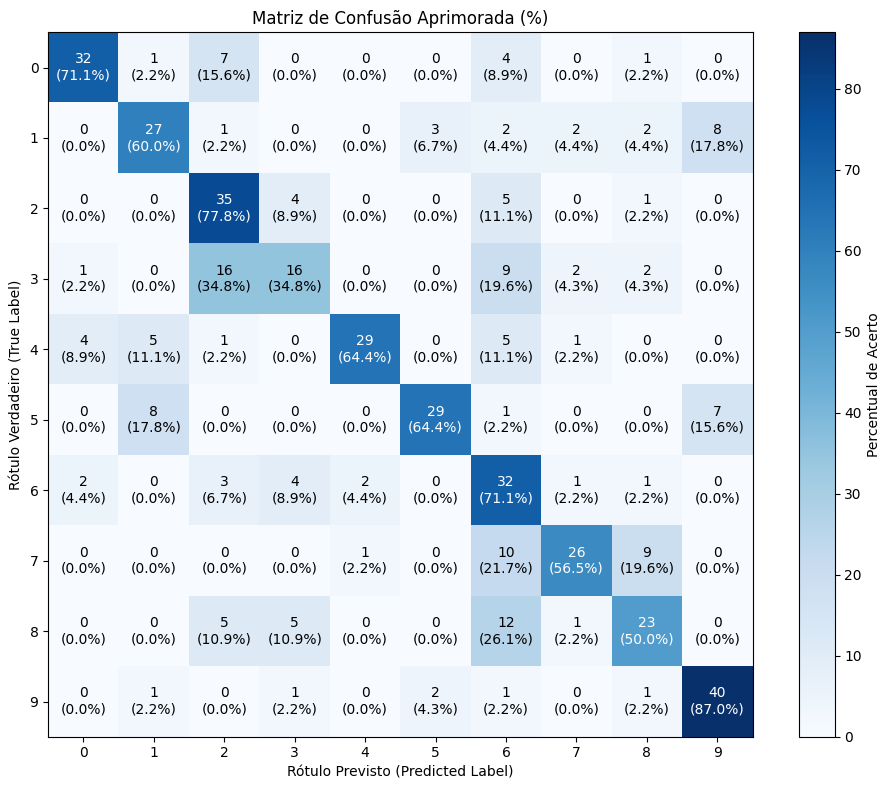

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

# Fazer previsões no conjunto de teste
y_pred_probs_aug = model_augmented_improved.predict(X_test_reshaped)

# Converter as probabilidades das previsões para classes (o índice com maior valor)
y_pred_classes_aug = np.argmax(y_pred_probs_aug, axis=1)

# Converter os rótulos verdadeiros (one-hot) para classes
y_true_classes_aug = np.argmax(y_test, axis=1)

# Calcular e imprimir a acurácia no conjunto de teste
test_accuracy_aug = accuracy_score(y_true_classes_aug, y_pred_classes_aug)
print(f"Acurácia no conjunto de teste (com aumento de dados): {test_accuracy_aug:.4f}")


# Gerar a matriz de confusão
cm_aug = confusion_matrix(y_true_classes_aug, y_pred_classes_aug)

# Plotar a matriz de confusão com contagens e percentuais
cm_percent = cm_aug.astype('float') / cm_aug.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
plt.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão Aprimorada (%)')
plt.colorbar(label='Percentual de Acerto')

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, label_encoder.classes_)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Rótulo Previsto (Predicted Label)')
plt.ylabel('Rótulo Verdadeiro (True Label)')

# Adicionar os valores numéricos (contagem e %) em cada célula
thresh = cm_percent.max() / 2.
for i, j in itertools.product(range(cm_aug.shape[0]), range(cm_aug.shape[1])):
    plt.text(j, i, f"{cm_aug[i, j]}\n({cm_percent[i, j]:.1f}%)",
             ha="center", va="center",
             color="white" if cm_percent[i, j] > thresh else "black")

plt.tight_layout()
plt.show()